In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window
%config InlineBackend.figure_format = 'retina'

In [2]:
def create_paint_df_ind_compressed(df, ind, mapping, ns_map):
    d = {}
    max_pos = int(df.epos.iloc[-1])
    df = df.loc[df[ind].shift() != df[ind]].reset_index()
    df["epos"] = pd.concat([df.spos.iloc[1:], pd.Series(max_pos)], ignore_index=True)
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

def length_to_windows(length_df, pops, window_size=100000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

In [3]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "../steps/rfmix_gen100/eth_olive_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

# north_south_mapping = {'Hamadryas, Ethiopia': 1,
#  'Kindae, Zambia': 0,
#  'Papio, Senegal': 1,
#  'Ursinus, Zambia': 0}


north_south_mapping = {'Hamadryas, Ethiopia': 1,
    'Papio, Senegal': 1,
    'Cynocephalus, Central Tanzania': 0,
    'Anubis, Tanzania': 0}

In [4]:
df_l = []
for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]:
# for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX"]:

    # if chrom != "all_chrX":
    #     continue
    print(chrom)

    
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind_compressed(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [5]:
length_df.head()

,pos,end_pos,length,reference,n/s,individual,haplotype,chrom
0,160,7134559,7134400,"Anubis, Tanzania",0,Sci_30877,0,chr1
1,7134560,7682952,548393,"Cynocephalus, Central Tanzania",0,Sci_30877,0,chr1
2,7682953,21932993,14250041,"Anubis, Tanzania",0,Sci_30877,0,chr1
3,21932994,22111111,178118,"Hamadryas, Ethiopia",1,Sci_30877,0,chr1
4,22111112,96741558,74630447,"Anubis, Tanzania",0,Sci_30877,0,chr1


In [6]:
length_df["haplo_ID"] = length_df.individual +"_"+ length_df.haplotype
length_df["start"] = length_df.pos
length_df["north"] = length_df["n/s"]*2-1
length_df["total_north"] = length_df["north"]*length_df.length
length_df

,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,haplo_ID,start,north,total_north
0,160,7134559,7134400,"Anubis, Tanzania",0,Sci_30877,0,chr1,Sci_30877_0,160,-1,-7134400
1,7134560,7682952,548393,"Cynocephalus, Central Tanzania",0,Sci_30877,0,chr1,Sci_30877_0,7134560,-1,-548393
2,7682953,21932993,14250041,"Anubis, Tanzania",0,Sci_30877,0,chr1,Sci_30877_0,7682953,-1,-14250041
3,21932994,22111111,178118,"Hamadryas, Ethiopia",1,Sci_30877,0,chr1,Sci_30877_0,21932994,1,178118
4,22111112,96741558,74630447,"Anubis, Tanzania",0,Sci_30877,0,chr1,Sci_30877_0,22111112,-1,-74630447
...,...,...,...,...,...,...,...,...,...,...,...,...
28,91954355,92441774,487420,"Cynocephalus, Central Tanzania",0,PD_0792,1,female_chrX,PD_0792_1,91954355,-1,-487420
29,92441775,92824755,382981,"Hamadryas, Ethiopia",1,PD_0792,1,female_chrX,PD_0792_1,92441775,1,382981
30,92824756,94470854,1646099,"Cynocephalus, Central Tanzania",0,PD_0792,1,female_chrX,PD_0792_1,92824756,-1,-1646099
31,94470855,95908432,1437578,"Hamadryas, Ethiopia",1,PD_0792,1,female_chrX,PD_0792_1,94470855,1,1437578


In [7]:
total_sort = (length_df.groupby(by=["haplo_ID", "individual", "reference"])[["total_north"]].sum()).sort_values(by="total_north",
                                                                          ascending=False).reset_index()

In [8]:
total_sort

,haplo_ID,individual,reference,total_north
0,PD_0730_1,PD_0730,"Hamadryas, Ethiopia",338653682
1,PD_0726_0,PD_0726,"Hamadryas, Ethiopia",335851283
2,PD_0730_0,PD_0730,"Hamadryas, Ethiopia",333771623
3,PD_0744_0,PD_0744,"Hamadryas, Ethiopia",332725753
4,PD_0744_1,PD_0744,"Hamadryas, Ethiopia",328142549
...,...,...,...,...
539,PD_0695_0,PD_0695,"Cynocephalus, Central Tanzania",-2871396315
540,PD_0693_0,PD_0693,"Cynocephalus, Central Tanzania",-2871440909
541,PD_0694_1,PD_0694,"Cynocephalus, Central Tanzania",-2872243730
542,PD_0693_1,PD_0693,"Cynocephalus, Central Tanzania",-2872289105


In [9]:
tanzania = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Central Tanzania",
                                                                "Anubis, Tanzania",
                                                                "Cynocephalus, Western Tanzania"])].PGDP_ID
olive = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Anubis, Tanzania"])].PGDP_ID
eth = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Anubis, Ethiopia"])].PGDP_ID
yellow = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Central Tanzania",
                                                                "Cynocephalus, Western Tanzania"])].PGDP_ID
western = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Western Tanzania"])].PGDP_ID
ruaha = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID

In [10]:
#chr_l_df.loc[chr_l_df.end_pos == chr_l_df.end_pos.max()]

In [11]:
length_df.sort_values(by=['individual', 'start'])

,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,haplo_ID,start,north,total_north
0,58,332845,332788,"Cynocephalus, Central Tanzania",0,PD_0228,0,chr5,PD_0228_0,58,-1,-332788
0,58,266099,266042,"Cynocephalus, Central Tanzania",0,PD_0228,1,chr5,PD_0228_1,58,-1,-266042
0,73,2019860,2019788,"Cynocephalus, Central Tanzania",0,PD_0228,0,chr20,PD_0228_0,73,-1,-2019788
0,73,153378,153306,"Cynocephalus, Central Tanzania",0,PD_0228,1,chr20,PD_0228_1,73,-1,-153306
0,114,1460812,1460699,"Cynocephalus, Central Tanzania",0,PD_0228,0,chr6,PD_0228_0,114,-1,-1460699
...,...,...,...,...,...,...,...,...,...,...,...,...
4,149133694,182831340,33697647,"Cynocephalus, Central Tanzania",0,Sci_34474,1,chr5,Sci_34474_1,149133694,-1,-33697647
2,149144379,183742108,34597730,"Cynocephalus, Central Tanzania",0,Sci_34474,0,chr5,Sci_34474_0,149144379,-1,-34597730
5,182831341,183005973,174633,"Anubis, Tanzania",0,Sci_34474,1,chr5,Sci_34474_1,182831341,-1,-174633
6,183005974,183742108,736135,"Cynocephalus, Central Tanzania",0,Sci_34474,1,chr5,Sci_34474_1,183005974,-1,-736135


In [39]:
#chr_l_df = length_df.loc[(length_df.chrom == "all_chrX") & (length_df.individual.isin(eth))]
chr_l_df = length_df.loc[(length_df.chrom == "female_chrX")]
# chr_l_df = length_df.loc[(length_df.chrom == "all_chrX")]
chr_l_df.sort_values(by=['haplo_ID', 'chrom', 'pos'], inplace=True)

chr_l_df.head()

/scratch/39767492/ipykernel_1069047/3505294313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_l_df.sort_values(by=['haplo_ID', 'chrom', 'pos'], inplace=True)


,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,haplo_ID,start,north,total_north
0,37,23680,23644,"Anubis, Tanzania",0,PD_0232,0,female_chrX,PD_0232_0,37,-1,-23644
1,23681,5036925,5013245,"Cynocephalus, Central Tanzania",0,PD_0232,0,female_chrX,PD_0232_0,23681,-1,-5013245
2,5036926,5308306,271381,"Papio, Senegal",1,PD_0232,0,female_chrX,PD_0232_0,5036926,1,271381
3,5308307,9008676,3700370,"Cynocephalus, Central Tanzania",0,PD_0232,0,female_chrX,PD_0232_0,5308307,-1,-3700370
4,9008677,10064936,1056260,"Papio, Senegal",1,PD_0232,0,female_chrX,PD_0232_0,9008677,1,1056260


In [40]:
chr_l_df.reference.unique()

array(['Anubis, Tanzania', 'Cynocephalus, Central Tanzania',
       'Papio, Senegal', 'Hamadryas, Ethiopia'], dtype=object)

In [41]:
total_sort

,haplo_ID,individual,reference,total_north
0,PD_0730_1,PD_0730,"Hamadryas, Ethiopia",338653682
1,PD_0726_0,PD_0726,"Hamadryas, Ethiopia",335851283
2,PD_0730_0,PD_0730,"Hamadryas, Ethiopia",333771623
3,PD_0744_0,PD_0744,"Hamadryas, Ethiopia",332725753
4,PD_0744_1,PD_0744,"Hamadryas, Ethiopia",328142549
...,...,...,...,...
539,PD_0695_0,PD_0695,"Cynocephalus, Central Tanzania",-2871396315
540,PD_0693_0,PD_0693,"Cynocephalus, Central Tanzania",-2871440909
541,PD_0694_1,PD_0694,"Cynocephalus, Central Tanzania",-2872243730
542,PD_0693_1,PD_0693,"Cynocephalus, Central Tanzania",-2872289105


In [42]:
# chr_l_df['id_and_pop'] = chr_l_df.haplo_ID + chr_l_df.reference.str.replace(', ', '_')
# total_sort['id_and_pop'] = total_sort.haplo_ID + total_sort.reference.str.replace(', ', '_')

chr_l_df['end'] = chr_l_df.end_pos

#chr_l_df['label'] = [f'{x}_{y}' for (x, y) in zip(chr_l_df.index, chr_l_df.reference.str.replace(', ', '_'))]
chr_l_df.head()

/scratch/39767492/ipykernel_1069047/2308216635.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_l_df['end'] = chr_l_df.end_pos


,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,haplo_ID,start,north,total_north,end
0,37,23680,23644,"Anubis, Tanzania",0,PD_0232,0,female_chrX,PD_0232_0,37,-1,-23644,23680
1,23681,5036925,5013245,"Cynocephalus, Central Tanzania",0,PD_0232,0,female_chrX,PD_0232_0,23681,-1,-5013245,5036925
2,5036926,5308306,271381,"Papio, Senegal",1,PD_0232,0,female_chrX,PD_0232_0,5036926,1,271381,5308306
3,5308307,9008676,3700370,"Cynocephalus, Central Tanzania",0,PD_0232,0,female_chrX,PD_0232_0,5308307,-1,-3700370,9008676
4,9008677,10064936,1056260,"Papio, Senegal",1,PD_0232,0,female_chrX,PD_0232_0,9008677,1,1056260,10064936


In [43]:
chr_l_df.loc[chr_l_df.haplo_ID == 'PD_0228_0']

,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,haplo_ID,start,north,total_north,end


In [44]:
window_df_l = []
# for chrom in length_df.chrom.unique():
for chrom in chr_l_df.chrom.unique():
    print(chrom)
    chrom_df = length_df.loc[length_df.chrom == "{}".format(chrom)]
    pops = chrom_df.reference.unique()
    for ind in chrom_df.individual.unique():
        ind_df = chrom_df.loc[chrom_df.individual == ind]
        window_df_ind = length_to_windows(ind_df, pops)
        window_df_ind["chrom"] = "{}".format(chrom)
        window_df_ind["individual"] = ind
        window_df_l.append(window_df_ind)
window_df = pd.concat(window_df_l)

female_chrX


In [45]:
window_df["Origin"] = window_df.individual.map(dict(zip(meta_data_samples.PGDP_ID,
                                                        meta_data_samples.Origin)))
window_df["Species"] = window_df.individual.map(dict(zip(meta_data_samples.PGDP_ID,
                                                        meta_data_samples.Species)))
window_df["north"] = window_df["Hamadryas, Ethiopia"]+window_df["Papio, Senegal"]
window_df["norm_north"] = (window_df.north-window_df.iloc[:,1:5].sum(axis=1)/2)
window_df["start"] = window_df["windows"]

In [46]:
window_df.head()

,windows,"Anubis, Tanzania","Hamadryas, Ethiopia","Papio, Senegal","Cynocephalus, Central Tanzania",chrom,individual,Origin,Species,north,norm_north,start
0,37,200000.0,0.0,0.0,0.0,female_chrX,Sci_30977,"Aberdare, Kenya",anubis,0.0,-100000.0,37
1,100037,200000.0,0.0,0.0,0.0,female_chrX,Sci_30977,"Aberdare, Kenya",anubis,0.0,-100000.0,100037
2,200037,200000.0,0.0,0.0,0.0,female_chrX,Sci_30977,"Aberdare, Kenya",anubis,0.0,-100000.0,200037
3,300037,200000.0,0.0,0.0,0.0,female_chrX,Sci_30977,"Aberdare, Kenya",anubis,0.0,-100000.0,300037
4,400037,200000.0,0.0,0.0,0.0,female_chrX,Sci_30977,"Aberdare, Kenya",anubis,0.0,-100000.0,400037


In [47]:
meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(window_df.individual), ['PGDP_ID', 'Species', 'Origin']].Species.unique().tolist()

['anubis', 'kindae', 'cynocephalus', 'ursinus (grayfoot)']

In [48]:
window_df['label'] = window_df.individual + '_' + window_df.Origin.str.replace(', ', '_') + '_' + window_df.Species.str.replace(', ', '_')


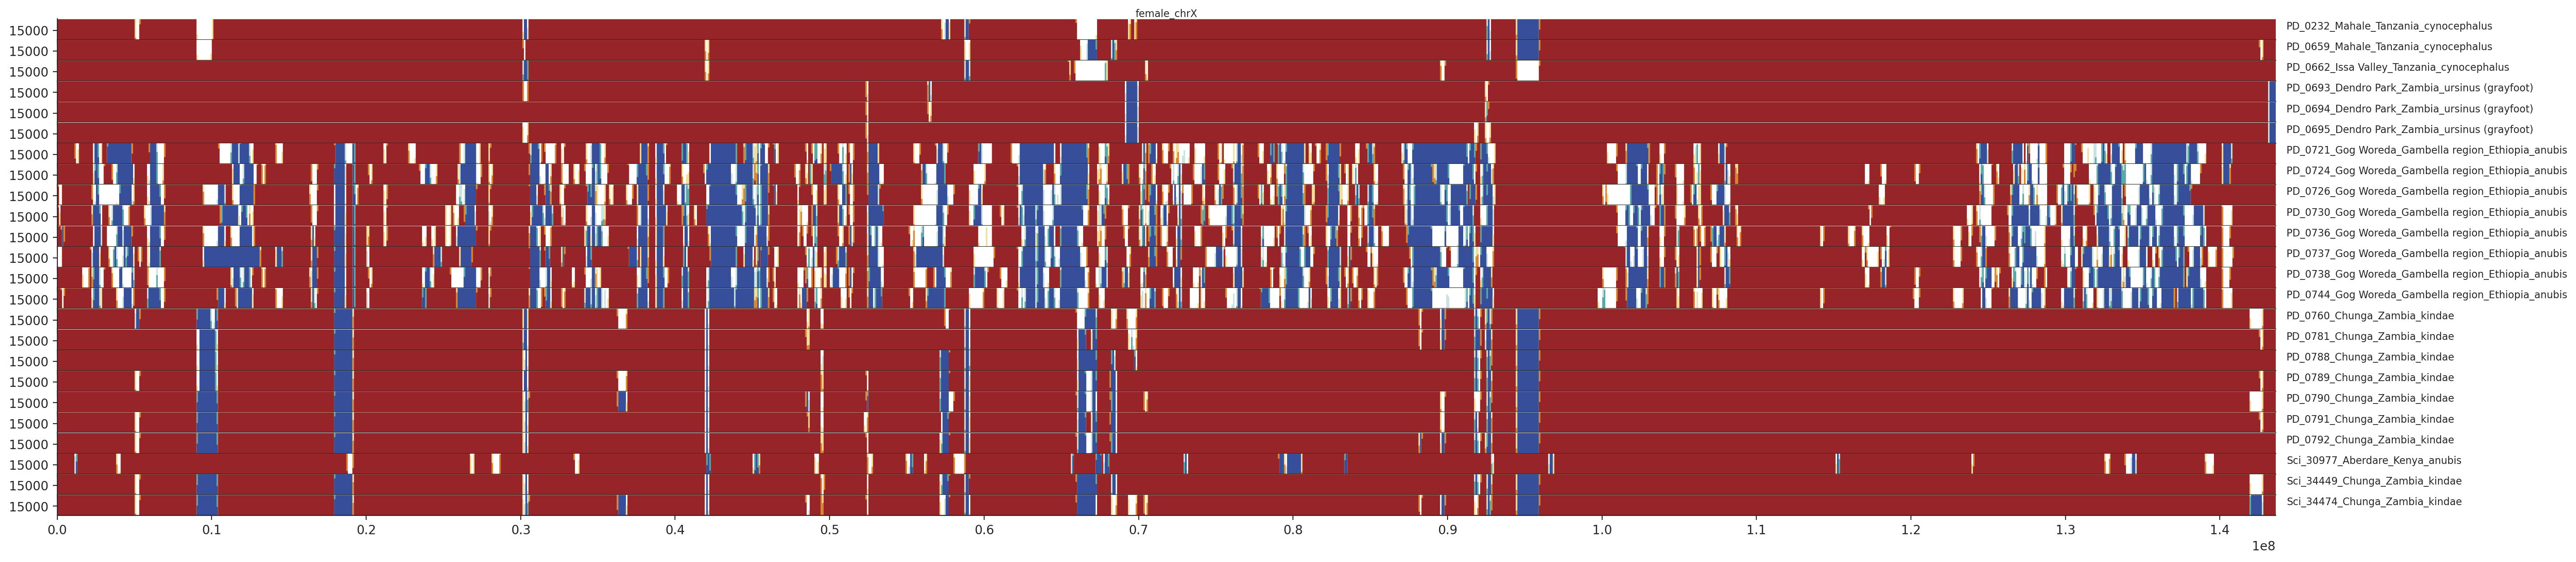

In [49]:
fig = horizonplot(window_df, 'norm_north', width=2, col='chrom', row='label', size=0.3, aspect=100)

In [17]:
# @window(size=100_000)
# def north_sum(df):
#     return (df.end-df.start).sum()

# df = chr_l_df.groupby(['chrom', 'haplo_ID'])[["end", "start"]].apply(north_sum).reset_index(drop=True, level=-1).reset_index()

# df.head()

,chrom,haplo_ID,start,end,north_sum
0,all_chrX,PD_0228_0,0,100000,0
1,all_chrX,PD_0228_0,100000,200000,0
2,all_chrX,PD_0228_0,200000,300000,0
3,all_chrX,PD_0228_0,300000,400000,0
4,all_chrX,PD_0228_0,400000,500000,0


(array([3.35000e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.34000e+02, 0.00000e+00, 0.00000e+00, 1.89074e+05]),
 array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
         70000.,  80000.,  90000., 100000.]),
 <BarContainer object of 10 artists>)

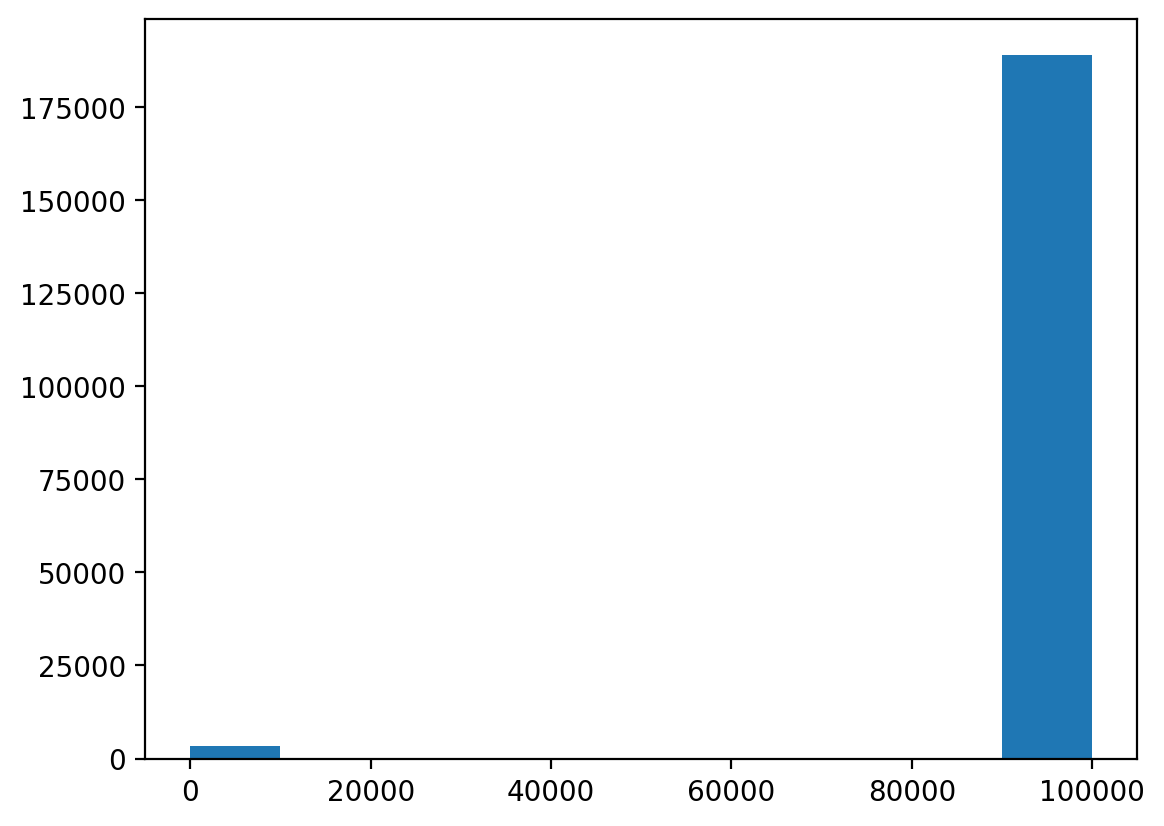

In [21]:
plt.hist(df.north_sum)

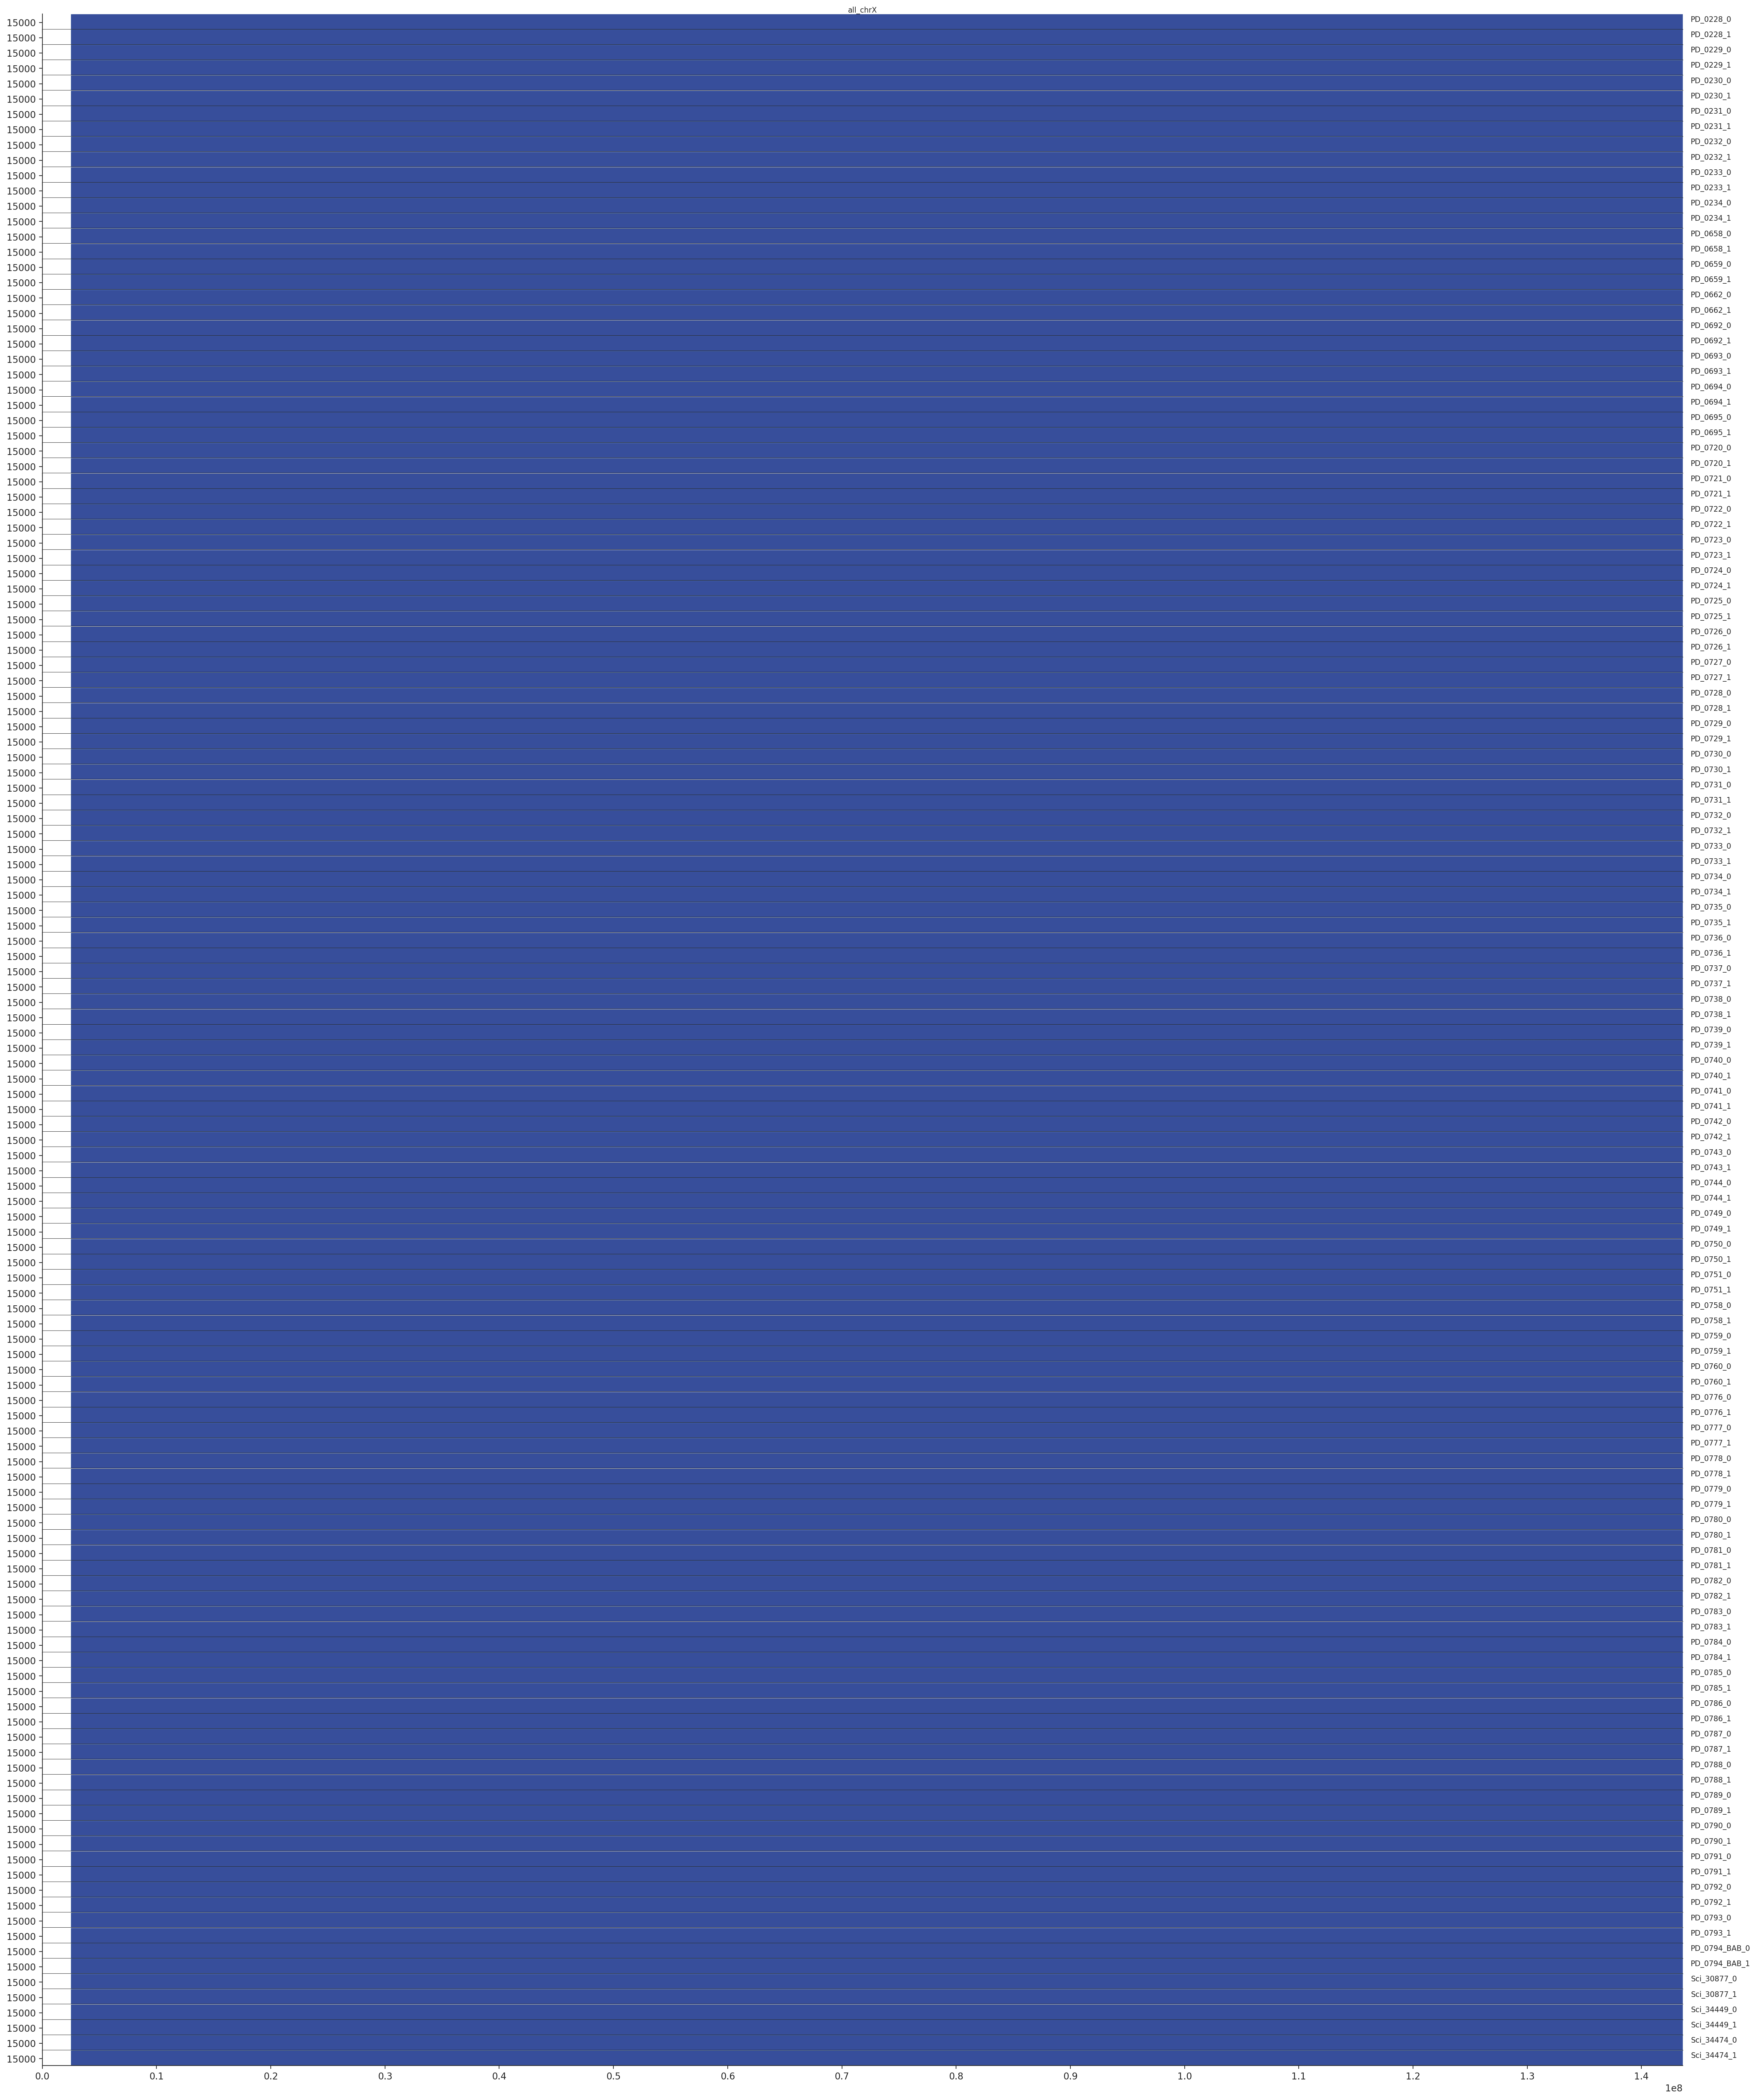

In [20]:
fig = horizonplot(df, 'north_sum', width=2, col='chrom', row='haplo_ID', 
                  size=0.3, aspect=100, 
#                    pop_sorting=total_sort.loc[total_sort.individual.isin(eth)].id_and_pop
                 )

In [20]:
fig = horizonplot(chr_l_df.head(1000), 'north', width=2, col='chrom', row='haplo_ID', size=0.3, aspect=100, cut=1/3,
# fig = horizonplot(chr_l_df.head(1000), 'north', width=2, col='chrom', row='id_and_pop', size=0.3, aspect=100, #cut=1/3,
                 # pop_sorting=total_sort.id_and_pop
                 pop_sorting=total_sort.haplo_ID
                 # pop_sorting=total_sort.loc[total_sort.individual.isin(western)].haplo_ID
                 )

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x14711a7ffca0> (for post_execute):



KeyboardInterrupt



In [6]:
@window(size=100000)
def north_sum(df):
    return (df.end-df.start).sum()

def add_dummy(c_df):
    inds = c_df.individual.unique()
    dummy_df = pd.DataFrame({"individual": np.repeat(inds, 2)})
    dummy_df["haplotype"] = pd.Series(["0", "1"]*len(inds))
    dummy_df["end"], dummy_df["start"] = c_df.end.max(), c_df.end.max()
    dummy_df["chrom"] = c_df.chrom.unique()[0]
    return dummy_df

rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"
df_l = []

for c in length_df.chrom.unique():
    output_file = rfmix_path + "{}.windows.txt".format(c)
    print(output_file)
    if os.path.exists(output_file) == False:
        c_df = length_df.loc[(length_df.chrom == c) & (length_df["n/s"] == 1)]
        c_df = c_df.rename(columns={"pos": "start", "end_pos": "end"})
        dummy_added = pd.concat([c_df, add_dummy(c_df)]).reset_index()
        df = dummy_added.groupby(['chrom', 'individual', 'haplotype'])[["end", "start"]].apply(north_sum).reset_index(drop=True, level=-1).reset_index()
        df.to_csv(output_file, index=False, sep="\t")

/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/chr1.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/chr2.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/chr3.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/chr4.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/chr5.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/chr6.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/chr7.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/chr8.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/r

In [7]:
df_l = []
for c in length_df.chrom.unique():
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df = pd.concat(df_l)

In [8]:
window_df.loc[window_df.end == 100000]

,chrom,individual,haplotype,start,end,north_sum
0,chr1,PD_0199,0,0,100000,99840
2175,chr1,PD_0199,1,0,100000,99840
4350,chr1,PD_0200,0,0,100000,99840
6525,chr1,PD_0200,1,0,100000,99840
8700,chr1,PD_0201,0,0,100000,99840
...,...,...,...,...,...,...
211239,female_chrX,Sci_16066,1,0,100000,0
212676,female_chrX,Sci_16098,0,0,100000,0
214113,female_chrX,Sci_16098,1,0,100000,0
215550,female_chrX,Sci_30977,0,0,100000,99963


In [9]:
x_df = window_df.loc[window_df.chrom.isin(["all_chrX"])]
autosomal_df = window_df.loc[~window_df.chrom.isin(["all_chrX", "female_chrX"])]

x_length = x_df.loc[x_df.individual == "PD_0199"].end.max()
percentage_north_x = ((x_df.groupby(by=["individual"])[["north_sum"]].sum())/(2*x_length))

aut_length = (autosomal_df.loc[autosomal_df.individual == "PD_0199"].end - \
              autosomal_df.loc[autosomal_df.individual == "PD_0199"].start).sum()
percentage_north_aut = ((autosomal_df.groupby(by=["individual"])[["north_sum"]].sum())/(aut_length))

x_aut_percent = percentage_north_x.merge(right=percentage_north_aut, on="individual")
sort_aut_x = x_aut_percent.sort_values(by="north_sum_y", ascending=False).reset_index()
aut_sort = sort_aut_x[["individual", "north_sum_y"]]
aut_sort = aut_sort.rename(columns={"north_sum_y": "North Percentage"})
aut_sort["chrom"] = "autosome"
x_sort = sort_aut_x[["individual", "north_sum_x"]]
x_sort = x_sort.rename(columns={"north_sum_x": "North Percentage"})
x_sort["chrom"] = "chrX"
concat_df = pd.concat([aut_sort, x_sort])

In [10]:
concat_df

,individual,North Percentage,chrom
0,PD_0202,0.969261,autosome
1,PD_0203,0.967011,autosome
2,PD_0199,0.966740,autosome
3,PD_0200,0.964175,autosome
4,PD_0201,0.962700,autosome
...,...,...,...
150,PD_0755,0.063212,chrX
151,PD_0272,0.056754,chrX
152,PD_0237,0.043484,chrX
153,PD_0236,0.046699,chrX


In [11]:
tanzania = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Central Tanzania",
                                                                "Anubis, Tanzania",
                                                                "Cynocephalus, Western Tanzania"])].PGDP_ID
olive = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Anubis, Tanzania"])].PGDP_ID
eth = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Anubis, Ethiopia"])].PGDP_ID
yellow = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Central Tanzania",
                                                                "Cynocephalus, Western Tanzania"])].PGDP_ID
ruaha = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


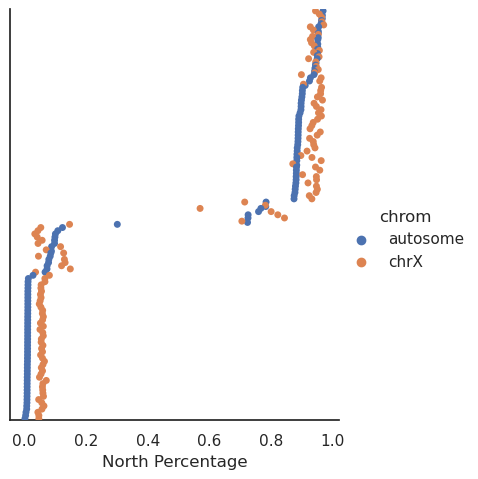

In [12]:
tanz_subset = concat_df.loc[concat_df.individual.isin(tanzania)]
ax = sns.catplot(data=tanz_subset, x="North Percentage", y="individual", hue="chrom", kind="swarm", legend_out=False)
ax.set(yticks=[], ylabel=None)

Also running the window conversion on the ethiopian olives

In [37]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Cynocephalus, Central Tanzania': 0,
 'Papio, Senegal': 0,
 'Anubis, Tanzania': 0}

In [38]:
mapping_df.Origin.unique()

array(['Cynocephalus, Central Tanzania', 'Hamadryas, Ethiopia',
       'Anubis, Tanzania', 'Papio, Senegal'], dtype=object)

In [39]:
df_l = []
for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind_compressed(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [40]:
@window(size=100000)
def north_sum(df):
    return (df.end-df.start).sum()

df_l = []

for c in length_df.chrom.unique():
    output_file = rfmix_path + "{}.windows.txt".format(c)
    print(output_file)
    if os.path.exists(output_file) == False:
        c_df = length_df.loc[(length_df.chrom == c) & (length_df["n/s"] == 1)]
        c_df = c_df.rename(columns={"pos": "start", "end_pos": "end"})
        df = c_df.groupby(['chrom', 'individual', 'haplotype'])[["end", "start"]].apply(north_sum).reset_index(drop=True, level=-1).reset_index()
        df.to_csv(output_file, index=False, sep="\t")

/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr1.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr2.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr3.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr4.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr5.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr6.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr7.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr8.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons

In [41]:
df_l = []
for c in length_df.chrom.unique():
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df_eth = pd.concat(df_l)

In [42]:
mean_df = window_df_eth.groupby(by=["individual", "chrom", "start"])[["north_sum"]].mean().reset_index()
mean_df["north"] = (mean_df.north_sum*2)-100000

In [51]:
window_df_eth

,chrom,individual,haplotype,start,end,north_sum
0,chr1,PD_0228,1,0,100000,0
1,chr1,PD_0228,1,100000,200000,0
2,chr1,PD_0228,1,200000,300000,0
3,chr1,PD_0228,1,300000,400000,0
4,chr1,PD_0228,1,400000,500000,0
...,...,...,...,...,...,...
58612,female_chrX,Sci_34474,1,142100000,142200000,100000
58613,female_chrX,Sci_34474,1,142200000,142300000,100000
58614,female_chrX,Sci_34474,1,142300000,142400000,100000
58615,female_chrX,Sci_34474,1,142400000,142500000,100000


In [52]:
ethiopia = meta_data_samples.loc[meta_data_samples.Origin == "Gog Woreda, Gambella region, Ethiopia"].PGDP_ID
eth_olive_mean_df = mean_df.loc[(mean_df.individual.isin(ethiopia))]

In [53]:
eth_olive_mean_df.groupby(["chrom"])[["north_sum"]].mean()/1000

,north_sum
chrom,
all_chrX,34.379003
chr1,10.089009
chr10,9.176671
chr11,7.385604
chr12,6.438671
chr13,6.599644
chr14,5.985083
chr15,6.793433
chr16,10.506777


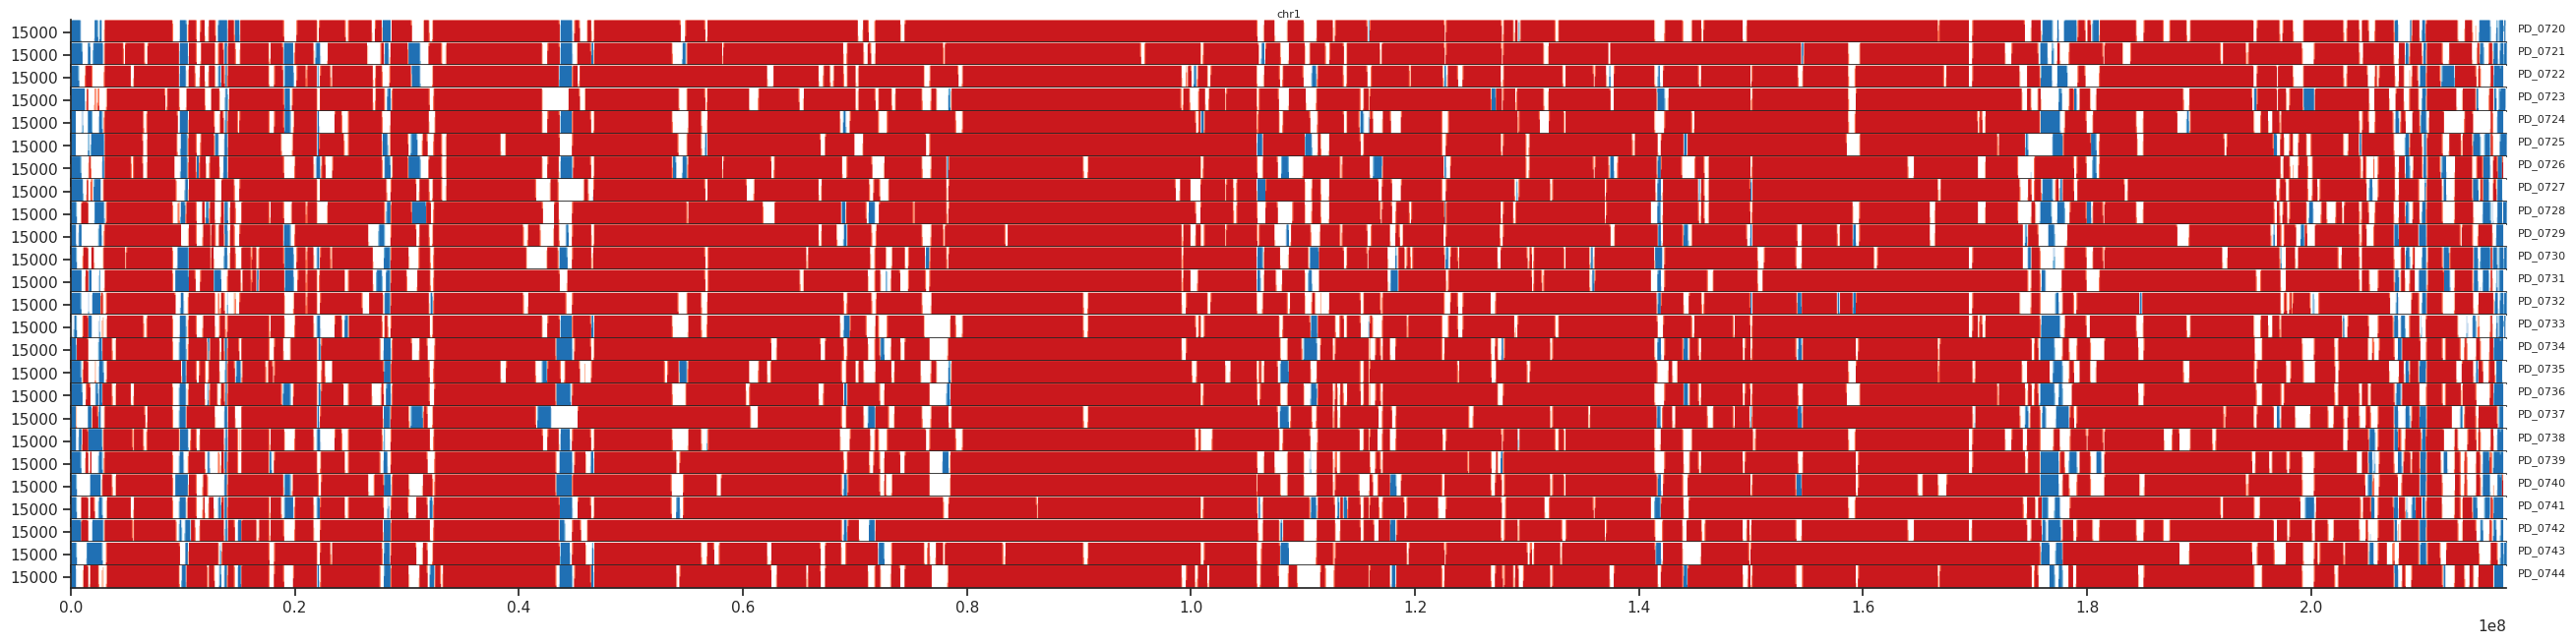

In [54]:
ind_test = mean_df.loc[(mean_df.individual.isin(ethiopia)) & (mean_df.chrom == "chr1")]
fig = horizonplot(ind_test, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

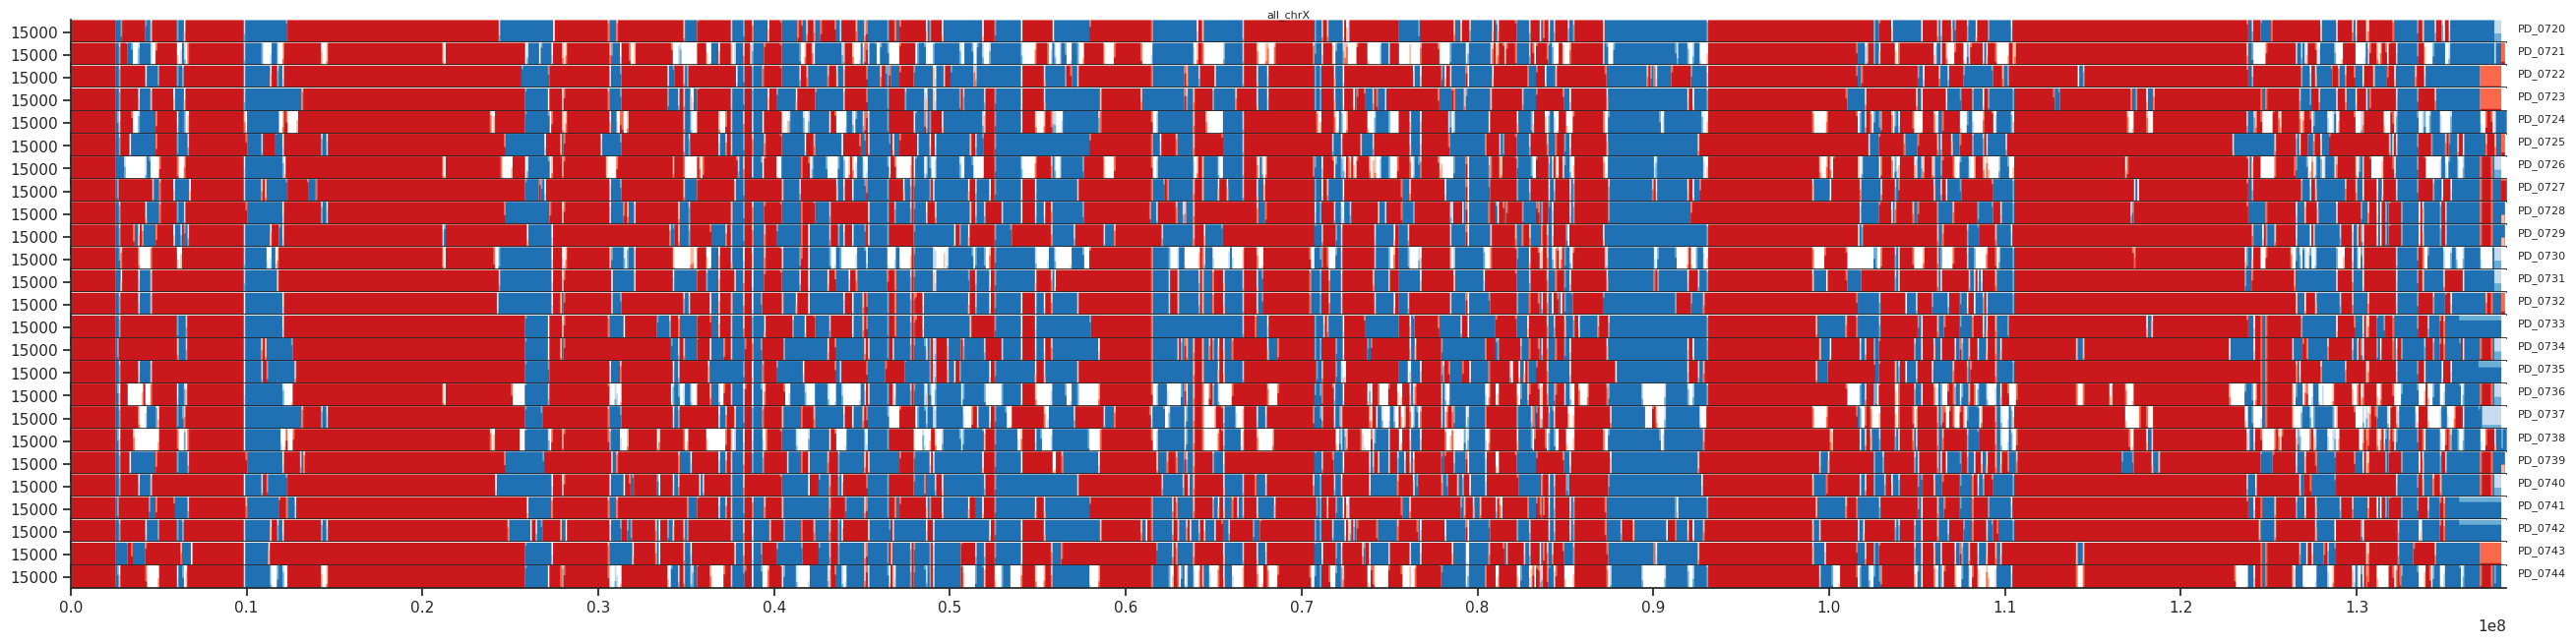

In [68]:
ind_test = mean_df.loc[(mean_df.individual.isin(ethiopia)) & (mean_df.chrom == "all_chrX")]
fig = horizonplot(ind_test, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)